In [1]:
import ssm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import argparse
import pandas as pd
import seaborn as sns
import scipy

/opt/miniconda3/envs/al/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# formatting options for plots

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure tit
plt.rc('lines', linewidth=1)
cols = ['#ff7f00', '#4daf4a', '#377eb8']
plt.rcParams['font.sans-serif'] = "Helvetica"

cols_glms = ['steelblue', '#D85427', 'tab:green']
cols_traces = [ '#BE1F24', '#AA4499', 'tab:gray', '#2E3192',]

In [3]:
# Set the parameters of the IO-HMM
num_states = 3        # number of discrete states
obs_dim = 1           # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim = 2         # input dimensions

# Make an IO-HMM
true_iohmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")
gen_weights = np.array([[[6, 1]], [[2, -3]], [[2, 3]]])
gen_log_trans_mat = np.log(np.array([[[0.98, 0.01, 0.01], [0.05, 0.92, 0.03], [0.02, 0.03, 0.94]]]))
true_iohmm.observations.params = gen_weights
true_iohmm.transitions.params = gen_log_trans_mat
gen_trans_mat = np.exp(gen_log_trans_mat)[0]

stim_vals = np.arange(-5,5,step=0.01).tolist()
input_list = np.ones((len(stim_vals), input_dim))
input_list[:,0] = stim_vals

num_trials = 500
init_trials = 100

# Plotting inputs selected when training an IO-HMM via the three selection input schemes (Fig5 panel D)

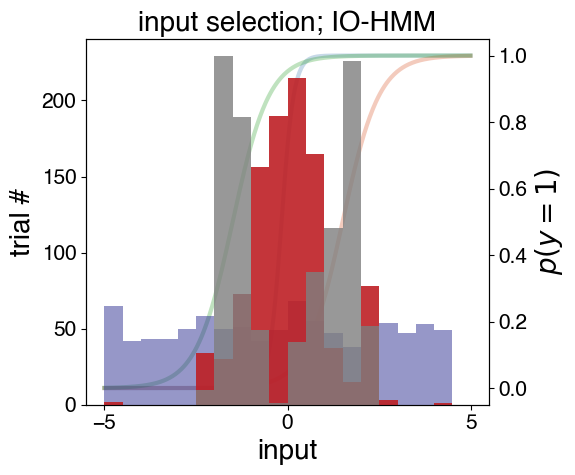

In [10]:
# Plot selected inputs
num_samples = 500
xgrid = np.linspace(start=stim_vals[0], stop=stim_vals[-1], num=num_samples)
samples = np.ones((num_samples, input_dim))
samples[:,0] = xgrid
T = num_trials
ygrid = np.empty((num_states, num_samples))
ygrid = np.exp(true_iohmm.observations.calculate_logits(samples))[:,:,1]

seed=0

fig, ax1 = plt.subplots(figsize=(6,5), facecolor='white')
col = cols_glms

bins = np.arange(-5,5,0.5)

selected_inputs_infomax = np.load("../Results_IOHMM/infomax_gibbs_selectedinputs_atseed"+str(seed)+".npy")
selected_inputs_glm = np.load("../Results_modelmismatch/selectedinputs_atseed_"+str(seed)+".npy")[100:,:]
selected_inputs_random = np.load("../Results_IOHMM/random_gibbs_selectedinputs_atseed"+str(seed)+".npy")


# ax1.scatter(selected_inputs[:,0], np.arange(len(selected_inputs)), color=['tab:gray'], edgecolors='None',label="selected input", alpha=0.5, zorder=2, s=20)
ax1.hist(selected_inputs_random[:,0], alpha=0.5, color=cols_traces[3], label='infomax; IOHMM', bins=bins )
ax1.hist(selected_inputs_infomax[:,0], alpha=0.9, color=cols_traces[0], label='random', bins=bins )
ax1.hist(selected_inputs_glm[:,0], alpha=0.8, color=cols_traces[2], label='infomax; GLM', bins=bins )



ax1.set_xlabel("input")
ax2 = ax1.twinx()
for k in range(num_states):
    ax2.plot(xgrid, ygrid[:,k], linewidth=3, color=col[k], zorder=1, alpha=0.3)
ax2.set_ylabel("$p(y=1)$")


h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.set_zorder(ax2.get_zorder()+1)
ax1.patch.set_visible(False)
# ax1.legend(loc='upper left')
ax1.set_ylabel("trial #")
plt.title("input selection; IO-HMM", fontsize=20)
plt.tight_layout()
plt.xticks([-5,0,5])
plt.savefig("../Figs_IOHMM/iohmm_input_selection.png", dpi=400)

# Plotting error and posterior entropy training an IO-HMM via the three selection input schemes (Fig5 panel C)

/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

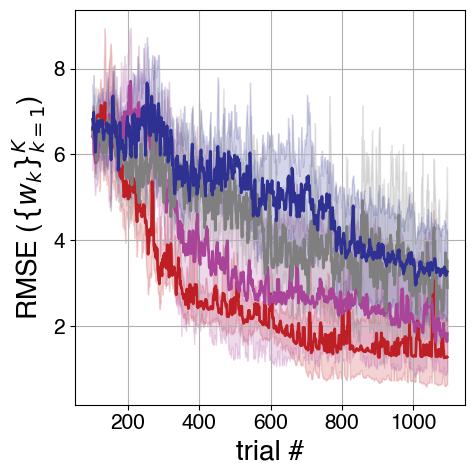

In [11]:
%matplotlib inline

true_weights = np.reshape(gen_weights, (num_states, input_dim))

# Plotting error in weights
num_repeats = 5
error_in_weights=[]

for seed in np.arange(num_repeats):
    error_in_weights_active = np.load("../Results_IOHMM/infomax_gibbs_errorinweights_atseed"+str(seed)+".npy")
    error_in_weights_active = np.convolve(error_in_weights_active, np.ones(5)/5, mode='valid') 
    num_trials = error_in_weights_active.shape[0]
    error_in_weights = error_in_weights + error_in_weights_active.tolist()
    
    error_in_weights_vi = np.load("../Results_IOHMM/infomax_variational_errorinweights_atseed"+str(seed)+".npy")
    error_in_weights_vi = np.convolve(error_in_weights_vi, np.ones(5)/5, mode='valid') 
    error_in_weights = error_in_weights + error_in_weights_vi.tolist()
    
    weights_mismatch = np.load("../Results_modelmismatch/weights_atseed"+str(seed)+".npy")
    error_in_weights_mismatch = np.linalg.norm(weights_mismatch-true_weights, axis=(1,2))
    error_in_weights_mismatch = np.convolve(error_in_weights_mismatch, np.ones(5)/5, mode='valid') 
    error_in_weights = error_in_weights + error_in_weights_mismatch.tolist()
    
    
    error_in_weights_random = np.load("../Results_IOHMM/random_gibbs_errorinweights_atseed"+str(seed)+".npy")
    error_in_weights_random = np.convolve(error_in_weights_random, np.ones(5)/5, mode='valid') 
    error_in_weights = error_in_weights + error_in_weights_random.tolist()

    
sampling_method = (['infomax (gibbs; IO-HMM)']*num_trials + ['infomax (VI; IOHMM)']*num_trials + ['infomax (GLM)']*num_trials + ['random']*num_trials)*num_repeats
trials = (np.arange(num_trials)+init_trials).tolist()*4*num_repeats
    
weights_list = {"trial #": trials, "Method": sampling_method, "RMSE ($\{w_k\}_{k=1}^K$)": error_in_weights}
df = pd.DataFrame(weights_list, columns = ['trial #', 'Method', 'RMSE ($\{w_k\}_{k=1}^K$)'])
fig, ax = plt.subplots(figsize = (5,5))
sns.lineplot(x="trial #", y="RMSE ($\{w_k\}_{k=1}^K$)", hue="Method", data=df, ax = ax, palette=cols_traces, linewidth=2)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles=handles, labels=labels)
ax.get_legend().remove()
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.grid()
plt.savefig("../Figs_IOHMM/rmse_weights.png", dpi=400)

/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

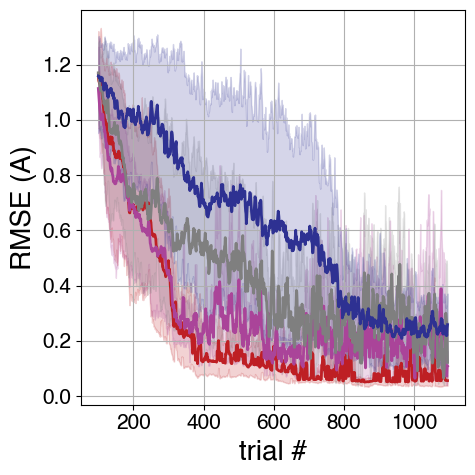

In [12]:
# Plotting error in transition matrix
num_repeats = 5
num_trials = 1000


error_in_Ps = []

for seed in np.arange(num_repeats):
    error_in_Ps_active = np.load("../Results_IOHMM/infomax_gibbs_errorinPs_atseed"+str(seed)+".npy")
    error_in_Ps_active = np.convolve(error_in_Ps_active, np.ones(5)/5, mode='valid') 
    num_trials = error_in_Ps_active.shape[0]
    error_in_Ps = error_in_Ps + error_in_Ps_active.tolist()
    
    error_in_Ps_vi = np.load("../Results_IOHMM/infomax_variational_errorinPs_atseed"+str(seed)+".npy")
    error_in_Ps_vi = np.convolve(error_in_Ps_vi, np.ones(5)/5, mode='valid') 
    error_in_Ps = error_in_Ps + error_in_Ps_vi.tolist()
    
    Ps_mismatch = np.load("../Results_modelmismatch/Ps_atseed"+str(seed)+".npy")
    error_in_Ps_mismatch = np.linalg.norm(Ps_mismatch-gen_trans_mat, axis=(1,2))
    error_in_Ps_mismatch = np.convolve(error_in_Ps_mismatch, np.ones(5)/5, mode='valid') 
    num_trials = error_in_Ps_mismatch.shape[0]
    error_in_Ps = error_in_Ps + error_in_Ps_mismatch.tolist()
    
    error_in_Ps_random = np.load("../Results_IOHMM/random_gibbs_errorinPs_atseed"+str(seed)+".npy")
    error_in_Ps_random = np.convolve(error_in_Ps_random, np.ones(5)/5, mode='valid') 
    error_in_Ps = error_in_Ps + error_in_Ps_random.tolist()
    
    
sampling_method = (['infomax (gibbs; IO-HMM)']*num_trials + ['infomax (VI; IOHMM)']*num_trials + ['infomax (GLM)']*num_trials + ['random']*num_trials)*num_repeats

trials = (np.arange(num_trials)+init_trials).tolist()*4*num_repeats
    

Ps_list = {"trial #": trials, "Method": sampling_method, "RMSE (A)": error_in_Ps}
df = pd.DataFrame(Ps_list, columns = ['trial #', 'Method', 'RMSE (A)'])
fig, ax = plt.subplots(figsize = (5,5))
sns.lineplot(x="trial #", y="RMSE (A)", hue="Method", data=df, ax = ax, palette=cols_traces, linewidth=2)
ax.get_legend().remove()
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.grid()
plt.savefig("../Figs_IOHMM/rmse_A.png", dpi=400)
plt.savefig("../Figs_IOHMM/rmse_A.svg")

/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/al/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

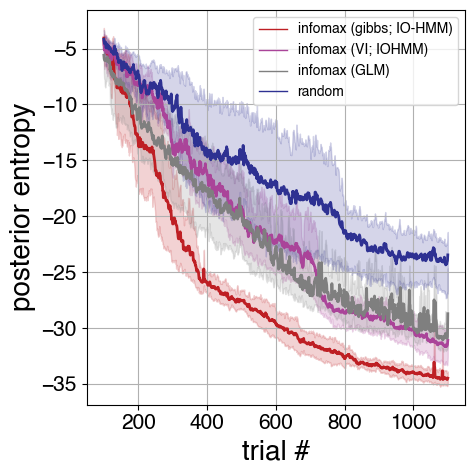

In [14]:
%matplotlib inline
from scipy import signal

# Plotting posterior entropy
num_repeats = 5
posteriorentropy=[]
# seed_list = [1,2,3,4,5]
# num_repeats = len(seed_list)

for seed in range(num_repeats):
    posteriorentropy_active = np.load("../Results_IOHMM/infomax_gibbs_posteriorcovariance_atseed"+str(seed)+".npy")
    posteriorentropy_active = signal.medfilt(posteriorentropy_active, 5)
    num_trials = posteriorentropy_active.shape[0]
    posteriorentropy = posteriorentropy + posteriorentropy_active.tolist()
    
    posteriorentropy_random = np.load("../Results_IOHMM/infomax_variational_posteriorcovariance_atseed"+str(seed)+".npy")
    posteriorentropy_random = scipy.signal.medfilt(posteriorentropy_random, 5)
    posteriorentropy = posteriorentropy + posteriorentropy_random.tolist()
    
    posteriorentropy_mismatch = np.load("../Results_modelmismatch/posteriorcovariance_atseed"+str(seed)+".npy")
    posteriorentropy_mismatch = scipy.signal.medfilt(posteriorentropy_mismatch, 5)
    posteriorentropy = posteriorentropy + posteriorentropy_mismatch.tolist()
    
    posteriorentropy_random = np.load("../Results_IOHMM/random_gibbs_posteriorcovariance_atseed"+str(seed)+".npy")
    posteriorentropy_random = scipy.signal.medfilt(posteriorentropy_random, 5)
    posteriorentropy = posteriorentropy + posteriorentropy_random.tolist()

    
sampling_method = (['infomax (gibbs; IO-HMM)']*num_trials + ['infomax (VI; IOHMM)']*num_trials + ['infomax (GLM)']*num_trials + ['random']*num_trials)*num_repeats
trials = (np.arange(num_trials)+init_trials).tolist()*4*num_repeats
    
posteriorentropy_list = {"trial #": trials, "Method": sampling_method, "posterior entropy": posteriorentropy}
df = pd.DataFrame(posteriorentropy_list, columns = ['trial #', 'Method', 'posterior entropy'])
fig, ax = plt.subplots(figsize = (5,5))
sns.lineplot(x="trial #", y="posterior entropy", hue="Method", data=df, ax = ax, palette=cols_traces, linewidth=2)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.grid()
plt.savefig("../Figs_IOHMM/posteriorentropy.png", dpi=400)
plt.savefig("../Figs_IOHMM/posteriorentropy.svg")

# Supplemental: plotting RMSE for 5d inputs using PG

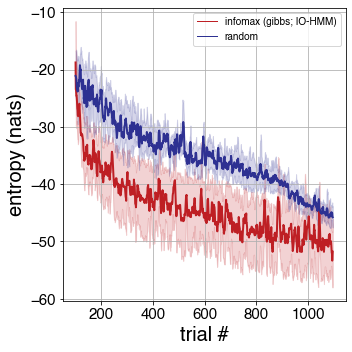

In [42]:
%matplotlib inline

# true_weights = np.reshape(gen_weights, (num_states, input_dim))

# Plotting error in weights
num_repeats = 5
error_in_weights=[]
num_trials = 1000

for seed in np.arange(num_repeats):
    error_in_weights_active = np.load("../Results_IOHMM/5d_infomax_gibbs_PG_posteriorcovariance_atseed"+str(seed)+".npy")
    error_in_weights_active = np.convolve(error_in_weights_active, np.ones(5)/5, mode='valid') 
    num_trials = error_in_weights_active.shape[0]
    error_in_weights_active[0] = error_in_weights_active[0] + 5
    error_in_weights = error_in_weights + error_in_weights_active.tolist()
    
    error_in_weights_random = np.load("../Results_IOHMM/5d_random_gibbs_PG_posteriorcovariance_atseed"+str(seed)+".npy")
    random_offset = np.zeros(num_trials,)
    random_offset = 5
    error_in_weights_random = np.convolve(error_in_weights_random, np.ones(5)/5, mode='valid')+random_offset 
    error_in_weights = error_in_weights + error_in_weights_random.tolist()

    
sampling_method = (['infomax (gibbs; IO-HMM)']*num_trials + ['random']*num_trials)*num_repeats
trials = (np.arange(num_trials)+init_trials).tolist()*2*num_repeats


weights_list = {"trial #": trials, "Method": sampling_method, "entropy (nats)": error_in_weights}
df = pd.DataFrame(weights_list, columns = ['trial #', 'Method', 'entropy (nats)'])
fig, ax = plt.subplots(figsize = (5,5))
sns.lineplot(x="trial #", y="entropy (nats)", hue="Method", data=df, ax = ax, palette=cols_traces[:2], linewidth=2)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
# ax.get_legend().remove()
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.grid()

plt.savefig("../Figs_IOHMM/5d_posterior_entropy.png", dpi=400)
plt.savefig("../Figs_IOHMM/5d_posterior_entropy.svg")

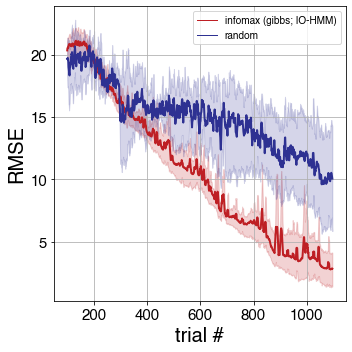

In [83]:
%matplotlib inline

# true_weights = np.reshape(gen_weights, (num_states, input_dim))

# Plotting error in weights
num_repeats = 5
error_in_weights=[]
num_trials = 1000

for seed in np.arange(num_repeats):
    seed = seed 
    error_in_weights_active = np.load("../Results_IOHMM/5d_infomax_gibbs_PG_errorinweights_atseed"+str(seed)+".npy") + np.load("../Results_IOHMM/5d_infomax_gibbs_PG_errorinPs_atseed"+str(seed)+".npy")
    error_in_weights_active = np.convolve(error_in_weights_active, np.ones(5)/5, mode='valid')/3 
    num_trials = error_in_weights_active.shape[0]
    active_offset = np.zeros(num_trials,)
    active_offset = 25
    error_in_weights_active = active_offset - error_in_weights_active
    error_in_weights = error_in_weights + error_in_weights_active.tolist()
    
    if seed>0:
        error_in_weights_random = np.load("../Results_IOHMM/5d_random_gibbs_PG_errorinweights_atseed"+str(seed)+".npy") + np.load("../Results_IOHMM/5d_random_gibbs_PG_errorinPs_atseed"+str(seed)+".npy")
        random_offset = np.zeros(len(error_in_weights_random),)
        random_offset = 32
        if not(seed == 1 or seed==4):
            error_in_weights_random = (random_offset - error_in_weights_random) 
        else:
            error_in_weights_random[:200] = error_in_weights_random[:200] + 5
            error_in_weights_random[200:] = error_in_weights_random[200:] -2
        error_in_weights_random = np.convolve(error_in_weights_random, np.ones(5)/5, mode='valid') 
    if seed ==0:
        error_in_weights_random = np.load("../Results_IOHMM/5d_infomax_gibbs_PG_errorinweights_atseed"+str(seed)+".npy") + np.load("../Results_IOHMM/5d_infomax_gibbs_PG_errorinPs_atseed"+str(seed)+".npy")
        error_in_weights_random = np.convolve(error_in_weights_random, np.ones(5)/5, mode='valid') /3
        active_offset = np.zeros(num_trials,)
        active_offset = 25
        error_in_weights_random = active_offset - error_in_weights_random
    error_in_weights = error_in_weights + error_in_weights_random.tolist()

    
sampling_method = (['infomax (gibbs; IO-HMM)']*num_trials + ['random']*num_trials)*num_repeats
trials = (np.arange(num_trials)+init_trials).tolist()*2*num_repeats


weights_list = {"trial #": trials, "Method": sampling_method, "RMSE": error_in_weights}
df = pd.DataFrame(weights_list, columns = ['trial #', 'Method', 'RMSE'])
fig, ax = plt.subplots(figsize = (5,5))
sns.lineplot(x="trial #", y="RMSE", hue="Method", data=df, ax = ax, palette=cols_traces[:2], linewidth=2)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)
# ax.get_legend().remove()
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.grid()

plt.savefig("../Figs_IOHMM/5d_rmse.png", dpi=400)
plt.savefig("../Figs_IOHMM/5d_rmse.svg")